In [ ]:
import torch
import torchvision
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm
print(torch.__version__)

1.6.0+cu101


In [ ]:
!pip install ipdb
import ipdb

  Created wheel for ipdb: filename=ipdb-0.13.3-cp36-none-any.whl size=10847 sha256=5a1a6cc3b2ce1bdd12bc45655e833930599b1f8df65a5ce919275a40ddc3dc54
  Stored in directory: /root/.cache/pip/wheels/75/00/30/4169bcc3643f0cf946dcf37af1b71364b390c4df91da02b03c
Successfully built ipdb


# PyTorch: The Basics

PyTorch allows you to dynamically define computational graphs. This is done by operating on `Variable`s, which wrap PyTorch's `Tensor` objects.

Here is an example, where we work with the function

$$f(x) = x^2 + 2x + 6$$

In [ ]:
def f(x):
    return x ** 2 + 2 * x + 6


In [ ]:
np_x = np.array([4.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)

In [ ]:
print(y)

tensor([30.], dtype=torch.float64, grad_fn=<AddBackward0>)


In [ ]:
y.backward()

In [ ]:
x.grad

tensor([10.], dtype=torch.float64)

In [ ]:
np_x = np.array([5.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)

In [ ]:
y.backward()

In [ ]:
x.grad

tensor([12.], dtype=torch.float64)

Unlike Tensorflow, we can define the graph on the fly. That is why it is more convenient to define a function in Python: we call the function as part of constructing the graph.

# Linear Classification with Pytorch

Let's now create a simple linear function for classifiying MNIST digits. Material is lifted from: https://github.com/fastai/fastai_old/blob/master/dev_nb/001a_nn_basics.ipynb

In [ ]:
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST('../data', train=False, download=True, transform=
                            transforms.ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [ ]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Label:  2


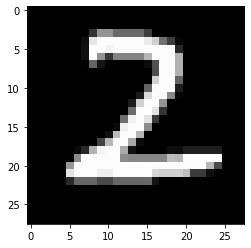

In [ ]:
i = 732  # try different indices
example = mnist_train[i]
print("Label: ", example[1])
plt.imshow(example[0].reshape((28,28)), cmap = plt.cm.gray)
plt.show()

Pytorch's DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches (it can shuffle and give you the next batch)

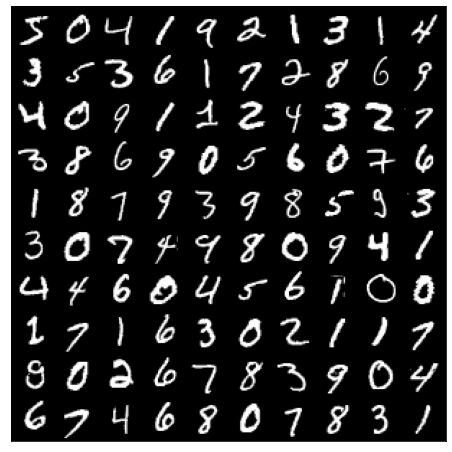

In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(mnist_train, batch_size=100, shuffle=False)

dataiter = iter(train_dl)
images, labels = dataiter.next()
viz = torchvision.utils.make_grid(images, nrow=10, padding = 2).numpy()
fig, ax = plt.subplots(figsize= (8,8))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Thanks to PyTorch's ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let's just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we'll write log_softmax and use it. Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.


In [ ]:
def log_softmax(x): 
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb, weights, bias):      
    return log_softmax(xb @ weights + bias)

def nll(input, target): 
    # input (prediction) shape = (batch_size, 10)
    # target shape = (batch_sise,)
    # input[range(batch_size), target] shape = (batch_size,)
    return -input[range(target.shape[0]), target].mean()

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

loss_func = nll

In the above, the '@' is syntactic sugar for the matrix multiply operation. We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won't be any better than random at this stage, since we start with random weights.

In [ ]:
lr = 0.1
epochs = 1
bs = 128

print_every = 100
in_shape = 784
out_shape = 10

train_dl = DataLoader(mnist_train, batch_size=bs)
test_dl = DataLoader(mnist_test, batch_size = 100)

# Initialize weights
weights = torch.randn(in_shape, out_shape) / math.sqrt(in_shape)
weights.requires_grad_()
bias = torch.zeros(out_shape, requires_grad=True)


for epoch in range(epochs):
    for i, (xb, yb) in enumerate(train_dl):
    
        xb = xb.view(xb.size(0), -1)
        
        # Evaluate training accuracy
        if i % print_every == 0: 
            print("Batch: ", i)
            print("Train acc on curr batch: ", accuracy(model(xb, weights, bias), yb).item())
            
        # Forward pass    
        pred = model(xb, weights, bias)
        loss = loss_func(pred, yb)

        # Backward pass
        loss.backward()
        with torch.no_grad():   # temporarily sets all the requires_grad flags to False
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            
        # Evaluate training accuracy
        if i % print_every == 0: 
            print("Train acc on curr batch (post-update): ", accuracy(model(xb, weights, bias), yb).item())
     


Batch:  0
Train acc on curr batch:  0.0546875
Train acc on curr batch (post-update):  0.2109375
Batch:  100
Train acc on curr batch:  0.8671875
Train acc on curr batch (post-update):  0.875
Batch:  200
Train acc on curr batch:  0.921875
Train acc on curr batch (post-update):  0.9296875
Batch:  300
Train acc on curr batch:  0.890625
Train acc on curr batch (post-update):  0.8984375
Batch:  400
Train acc on curr batch:  0.84375
Train acc on curr batch (post-update):  0.84375


Because the classifer is a linear model, the weight parameters connected to each output class can be viewed as an image as well (28x28, same size as the input). We visualize the weights below. They tell us how the linear classifer weighs the pixels of the input image to make predictions.

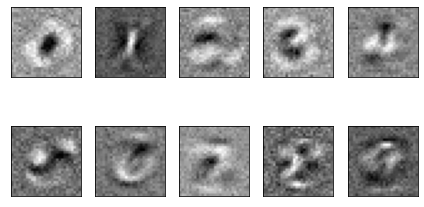

In [ ]:
nrows = 2
ncols = 5
weights_np = weights.detach().cpu().numpy()
fig, axes = plt.subplots(nrows=2, ncols=5, )
for i in range(nrows):
    for j in range(ncols):
        # axes[i, j].imshow(np.maximum(0.0, weights_np[:, i * ncols + j]).reshape((28, 28)), cmap='gray')#plt.cm.coolwarm)
        axes[i, j].imshow(weights_np[:, i * ncols + j].reshape((28, 28)), cmap='gray')#plt.cm.coolwarm)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.tight_layout()
plt.show()

The above training loop is a bit clunky and error-prone. Moreover, the code would get very messy if our model is larger and more complicated. In the following example, we will take advantage of Pytorch's built-in functionalities to build more powerful models.

# Neural Network with Pytorch

 We first introduce a helper function for evaluating neural networks.

In [ ]:
def get_test_stat(model, dl, device):
    model.eval()    # set model to eval mode
    cum_loss, cum_acc = 0.0, 0.0
    for i, (xb, yb) in enumerate(dl):
        xb = xb.to(device)
        yb = yb.to(device)
        
        xb = xb.view(xb.size(0), -1)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        cum_loss += loss.item() * len(yb)
        cum_acc += acc.item() * len(yb)
    cum_loss /= 10000
    cum_acc /= 10000
    model.train()   # set model back to train mode
    return cum_loss, cum_acc

Then, we build a neural network with one hidden layer, by extending the `torch.nn.Module` class. This allows us to keep the code modularized, and is how larger and more complicated models (e.g. ConvNets) are usually built in Pytorch.

In [ ]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()

        # define the parameters here
        self.fc = torch.nn.Linear(input_dim, hidden_dim)          # first layer
        self.out_layer = torch.nn.Linear(hidden_dim, output_dim)  # output layer
    
    def forward(self, x):   # defines the forward pass (overwriting the default method)
        out = self.fc(x)            # pass input through the first layer
        out = F.relu(out)           # apply ReLU activation
        out = self.out_layer(out)   # pass through the output layer
        return out

We can now train the network. Note that instead of manually updating the weights ourselves, we use a built-in Pytorch optimizer here `torch.optim.SGD`. Many other optimizers are available too (https://pytorch.org/docs/stable/optim.html).

In [ ]:
learning_rate = 1e-2
epochs = 10

dim_x = 784
dim_h = 100
dim_out = 10

# instantiate the model
model = Net(dim_x, dim_h, dim_out)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# create datasets and data loader
mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST('../data', train=False, download=True, transform=
                            transforms.ToTensor())
train_dl = DataLoader(mnist_train, batch_size=bs)
test_dl = DataLoader(mnist_test, batch_size = 100)

# Using GPUs in PyTorch is pretty straightforward
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"

model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

# set the model to training mode
model.train()

train_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
test_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}

pbar = tqdm(range(epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch {epoch + 1} / 10")
    train_loss = 0.0
    train_acc = 0.0
    for i, (xb, yb) in enumerate(train_dl):
        xb = xb.to(device)
        yb = yb.to(device)
        xb = xb.view(xb.size(0), -1)
        
        # Forward pass
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = accuracy(y_pred, yb)
        # Backward pass
        model.zero_grad()  # Zero out the previous gradient computation
        loss.backward()    # Compute the gradient
        optimizer.step()   # Use the gradient information to make a step
        train_stats['epoch'].append(epoch + i / len(train_dl))
        train_stats['loss'].append(loss.item())
        train_stats['acc'].append(acc.item())
    
    test_loss, test_acc = get_test_stat(model, test_dl, device)
    test_stats['epoch'].append(epoch + 1)
    test_stats['loss'].append(test_loss)
    test_stats['acc'].append(test_acc)


Using cuda


Plot training and test loss & accuracy curves.


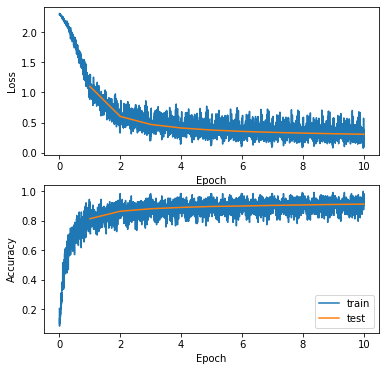

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
axes[0].plot(train_stats['epoch'], train_stats['loss'], label='train')
axes[0].plot(test_stats['epoch'], test_stats['loss'], label='test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].plot(train_stats['epoch'], train_stats['acc'], label='train')
axes[1].plot(test_stats['epoch'], test_stats['acc'], label='test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.show()


## Weight visualization

We visualize the learned weights in the first layer of the network as images. Compared to the linear model before, this model has 100 hidden units with ReLU activation, enabling it to make use of a more diverse set of features.

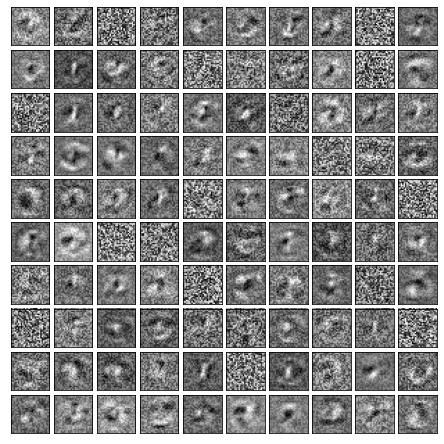

In [ ]:
nrows = 10
ncols = 10
first_layer_weights = model.fc.weight.detach().cpu().numpy()
fig, axes = plt.subplots(nrows=ncols, ncols=ncols, figsize=(6, 6))
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(first_layer_weights[i * ncols + j].reshape((28, 28)), cmap='gray')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.tight_layout(pad=0.1)
plt.show()

## [Exercise] What input activates an output class the most?
Unlike the linear model, we cannot directly visualize the weights connected to each output class. Instead, we will solve an optimization problem. Specifically, we will:

1. Choose an output class you'd like to visualize (e.g. '2'). Initialize the input to be a random image.
2. Compute the forward pass through the network.
3. Compute the gradient of the output unit w.r.t. the *input*.
4. Do a gradient ascent step on the *input*.
5. Repeat step 2-4 until a satisfactory visualization is obtained.

Optimizing the input to maximize the activation of some feature unit (in this case, an output unit) is a technique for feature visualization. This exercise only gives a naive example, and would probably not produce satisfactory visualizations on larger models and more diverse datasets (e.g. large ConvNet models on ImageNet). See [this article](https://distill.pub/2017/feature-visualization/) for techniques and fun examples of feature visualizations on GoogleNet trained on Imagenet.

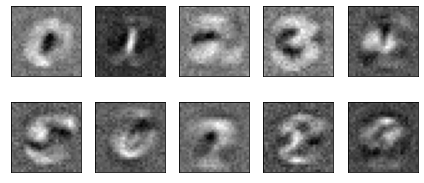

In [ ]:
input_lr = 0.01
input_train_itr = 200

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(6, 3))
pbar = tqdm(range(10))


for class_i in pbar:
    pbar.set_description(f"Visualizing class '{class_i}'")

    # 1. Initialize the input image.
    ### YOUR CODE HERE ###
    input_img = torch.normal(mean=torch.zeros((784,)), std=0.001).to(device)

    # we need to do optimization on imput_img, hence set the requires_grad flag
    input_img.requires_grad = True

    # define the gradient descent optimizer on input_img
    input_optim = torch.optim.SGD([input_img], lr=input_lr)

    for train_i in range(input_train_itr):
        # 2. Compute the forward pass through the network.
        ### YOUR CODE HERE ###
        model_out = model(input_img)
        neg_output = -1 * model_out[class_i]

        # 3. backward pass
        ### YOUR CODE HERE ###
        input_optim.zero_grad()       
        neg_output.backward()

        # 4. Do a gradient ascent step on the input
        ### YOUR CODE HERE ###
        input_optim.step()

    # plot the optimized input_img
    axes[class_i // 5, class_i % 5].imshow(input_img.detach().cpu().numpy().reshape((28, 28)), cmap='gray')
    axes[class_i // 5, class_i % 5].set_xticks([])
    axes[class_i // 5, class_i % 5].set_yticks([])

plt.tight_layout()
plt.show()